# RNA-Seq Analysis Training Demo

## Overview:

This code provides a comprehensive framework for analyzing RNA-Seq data to identify differentially expressed genes and investigate potential regulatory mechanisms. 

The code will analyze read count data, followed by differential expression analysis utilizing the DESeq2 and edgeR packages to pinpoint genes with statistically significant expression changes between experimental groups. 

Additionally, the code explores the regulatory landscape by identifying potential transcription factors (TFs) involved in modulating these differentially expressed genes using the NetAct package. 

It further estimates TF activity levels and constructs networks of interactions among these TFs. 

Overall, this demo serves to illustrates the essential steps in RNA-Seq analysis, emphasizing the identification of differential expression and the exploration of TF regulatory networks.

## STEP 1: Install Packages

### STEP 1.1 Install Mambaforge

First install Miniforge.

In [ ]:
# Download Miniforge
system('curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh', intern = TRUE)

# Install Miniforge
system('bash Miniforge3-$(uname)-$(uname -m).sh -b -u -p $HOME/miniforge', intern = TRUE)

# Add Miniforge bin to the system path
Sys.setenv(PATH = paste(Sys.getenv("HOME"), "/miniforge/bin:", Sys.getenv("PATH"), sep = ""))


Next, using mambaforge and bioconda, install the tools that will be used in this tutorial.

In [ ]:
# Install gsutil and dependencies using mamba
system('mamba install -y -c conda-forge -c bioconda gsutil', intern = TRUE)

### STEP 1.2 Install Bioconductor Packages

In [ ]:
# Install BiocManager if not installed
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Set repositories
options(repos = BiocManager::repositories())

# Install Bioconductor packages
BiocManager::install(c("ComplexHeatmap", "DESeq2", "edgeR"), force = TRUE)

# Install CRAN packages
install.packages(c("dplyr", "pheatmap", "ggrepel", "ggfortify", "devtools", "R.utils"), dependencies = TRUE)

### STEP 1.3 Load libraries

In [1]:
library(DESeq2)
library(dplyr)
library(ComplexHeatmap)
library(edgeR)
library(ggplot2)
library(ggrepel)
library(ggfortify)
library(devtools)
library(Biobase)
library(R.utils)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



### STEP 1.4 Install and Load NetAct from GitHub

In [2]:
#devtools::install_github("lusystemsbio/NetAct", dependencies = TRUE, build_vignettes = FALSE)
# Load NetAct
library(NetAct)

Warning message:
“replacing previous import ‘mclust::logsumexp’ by ‘limma::logsumexp’ when loading ‘NetAct’”






## STEP 2: Download FASTQ Files from S3

Download the read counts from the S3 bucket created by STAR and RSEM analysis in Tutorial 1b.

In [3]:
# Define the correct path for your files
path <- "data/counts/"

# Load SRR IDs from accs.txt (if available)
accs <- readLines('accs.txt')

# Define the path to the S3 bucket
s3_path <- 's3://sra-data-athena/readcounts/'

# STEP 5: Download FASTQ files from S3 bucket
for (acc in accs) {
  # Construct the command
  cmd <- paste("aws s3 cp", paste0(s3_path, acc, ".genes.txt"), "data/counts/")
  
  # Execute the shell command
  system(cmd)
}

In [4]:
# Define the correct path for your files
path <- "data/counts/"

# Load SRR IDs from accs.txt (if available)
accs <- readLines('accs.txt')

# Define the base URL for the S3 bucket
base_url <- 'https://sra-data-athena.s3.amazonaws.com/readcounts/'

# STEP 5: Download gene count files using wget
for (acc in accs) {
  # Construct the full URL for each file
  file_url <- paste0(base_url, acc, ".genes.txt")
  
  # Construct the wget command
  cmd <- paste("wget -P", path, file_url)
  
  # Execute the shell command
  system(cmd)
}

## STEP 3: Read Count Data and Define Experimental Groups

Step 3 is focused on reading in the gene expression data from previously generated files and organizing it for further analysis, specifically for differential expression analysis using the edgeR package.

In [5]:
# List the files with full paths
files <- paste0(path, c("SRR21972725.genes.txt", "SRR21972724.genes.txt", 
                        "SRR21972723.genes.txt", "SRR21972726.genes.txt",
                        "SRR21972730.genes.txt", "SRR21972729.genes.txt", 
                        "SRR21972728.genes.txt", "SRR21972727.genes.txt"))

# Read the DGE data from the files
x <- edgeR::readDGE(files, columns=c("GeneID","Count"))
x$counts <- round(x$counts)

# Define the group factor
group <- as.factor(c("PSAP", "PSAP", "PSAP", "PSAP", "GFP", "GFP", "GFP", "GFP"))
xgroup <- group

# Define the sample names and set column names
samplenames <- c("PSAP1", "PSAP2", "PSAP3", "PSAP4", "GFP1", "GFP2", "GFP3", "GFP4")
colnames(x) <- samplenames

## STEP 4: Data Preprocessing for Differential Expression Analysis

This preprocesses the RNA-seq count data to prepare it for differential expression analysis. It creates a comparison list for the analysis, constructs phenotype data to annotate samples, preprocesses the counts, and removes any duplicate gene entries. These steps ensure the quality and integrity of the data before applying statistical methods to identify differentially expressed genes between the specified groups.

In [6]:
compList <- c("PSAP-GFP")
phenoData = new("AnnotatedDataFrame", data = data.frame(celltype = group))
rownames(phenoData) = colnames(x$counts)

In [7]:
counts <- Preprocess_counts(counts = x$counts, groups = group, mouse = TRUE)
# Remove duplicate rows, keeping the first occurrence
counts <- counts[!duplicated(rownames(counts)), ]

'select()' returned 1:many mapping between keys and columns



### STEP 5: Run Differential Expression Analysis and Create Expression Set

This step identifies genes that are differentially expressed between the specified experimental groups and prepares the data for downstream analysis by creating a structured expression set object

In [8]:
DErslt = RNAseqDegs_limma(counts = counts, phenodata = phenoData, 
                          complist = compList, qval = 0.05)

       PSAP-GFP
Down       3707
NotSig     5994
Up         3748


In [9]:
neweset = Biobase::ExpressionSet(assayData = as.matrix(DErslt$e), phenoData = phenoData)

In [10]:
DErslt$e

,PSAP1,PSAP2,PSAP3,PSAP4,GFP1,GFP2,GFP3,GFP4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,6.7164143,6.82763504,6.8100748,6.7119839,6.8214550,6.9096076,6.9090701,6.8856556
Cdc45,1.7080006,1.79952434,1.6122561,1.7777365,1.2455156,1.2736813,1.7404024,1.3977717
H19,5.9975511,5.66302234,5.7837896,6.4917061,3.4806388,3.4891873,3.5311453,4.1733012
Scml2,0.4278927,-0.03479763,0.4977442,-0.1161763,-0.1245961,0.3866902,0.2048520,-0.1663573
Narf,6.6299847,6.71326860,6.6113505,6.5291864,6.7213673,6.6539900,6.6697381,6.4592337
Cav2,8.4649583,8.64076002,8.5839612,8.6988963,7.6899108,7.7256860,7.9406559,7.7762202
Klf6,7.0381986,7.12202482,7.1584377,7.0518035,6.7166271,6.7839399,6.8702597,6.8527850
Scmh1,3.7886401,3.99383823,3.8702119,3.9301741,3.8702910,4.0470525,3.9602792,4.0601844
Cox5a,7.9986356,8.07185172,8.0350808,7.9605596,7.6437131,7.6497504,7.6206578,7.3589740


### STEP 6: Perform Transcription Factor (TF) Selection

This step will identify transcription factors (TFs) that are potentially involved in regulating the differentially expressed genes. By utilizing a database of TFs and employing statistical testing, this analysis aims to uncover crucial regulators that may contribute to the observed changes in gene expression.

In [11]:
data("mDB")
calc <- TRUE

if (calc) {
  gsearslts <- TF_Selection(GSDB = mDB, DErslt = DErslt, minSize = 5, nperm = 10000,
                            qval = 0.05, compList = compList,
                            nameFile = "mouse_gsearslts")
} else {
  gsearslts <- readRDS(file = "mouse_gsearslts.RDS")
}

tfs <- gsearslts$tfs
tfs

start calculating ......



calculations finished !!!!!!



[1] "Ar"       "Arnt"     "Atf2"     "Atf4"     "Atf6"     "Cebpa"   
 [7] "Cebpb"    "Cebpd"    "Creb1"    "Crebbp"   "Ctnnb1"   "Dbp"     
[13] "E2f1"     "Ebf1"     "Egr1"     "Ep300"    "Esr1"     "Ets1"    
[19] "Fos"      "Foxo1"    "Foxo3"    "Foxo4"    "Gli2"     "Hdac1"   
[25] "Irf1"     "Jun"      "Junb"     "Mitf"     "Myc"      "Myod1"   
[31] "Nfe2l2"   "Nfic"     "Nfkb1"    "Nr1h3"    "Nr1i2"    "Nr1i3"   
[37] "Ppara"    "Ppard"    "Pparg"    "Ppargc1a" "Rel"      "Rela"    
[43] "Rxra"     "Rxrb"     "Rxrg"     "Sf1"      "Smad1"    "Smad2"   
[49] "Smad4"    "Smarca4"  "Sox5"     "Sp1"      "Srebf1"   "Srebf2"  
[55] "Srf"      "Stat1"    "Stat3"    "Stat4"    "Tbp"      "Tbx2"    
[61] "Trp53"    "Usf1"     "Usf2"

### STEP 7: Reselect Transcription Factors (TFs) by Applying a Stricter q-value Threshold of 0.01

The revised text accurately conveys the purpose of this step. By applying a stricter q-value threshold of 0.01, the code refines the selection of TFs, ensuring that only those with a higher level of statistical significance are retained. This refinement is crucial for downstream analyses as it helps to prioritize the most relevant TFs that may be driving the observed gene expression changes.

In [12]:
Reselect_TFs(GSEArslt = gsearslts$GSEArslt, qval = 0.01)

[1] "Ar"       "Cebpa"    "Cebpb"    "Creb1"    "Ctnnb1"   "Ebf1"    
 [7] "Egr1"     "Ep300"    "Foxo1"    "Jun"      "Nfkb1"    "Nr1i3"   
[13] "Ppara"    "Ppard"    "Pparg"    "Ppargc1a" "Rel"      "Rxra"    
[19] "Rxrb"     "Smad4"    "Sox5"     "Sp1"      "Srebf1"   "Srebf2"  
[25] "Stat1"    "Stat3"    "Tbp"      "Trp53"

### STEP 8: Calculate TF Activity

Calculating TF activity is crucial for understanding the regulatory mechanisms underlying the differential expression of genes. By assessing how active specific transcription factors are in different experimental groups, researchers can gain insights into the regulatory networks that may influence biological processes and pathways of interest. The heatmap visualization further aids in the interpretation of these results, highlighting the relationships between TF activity and gene expression patterns.

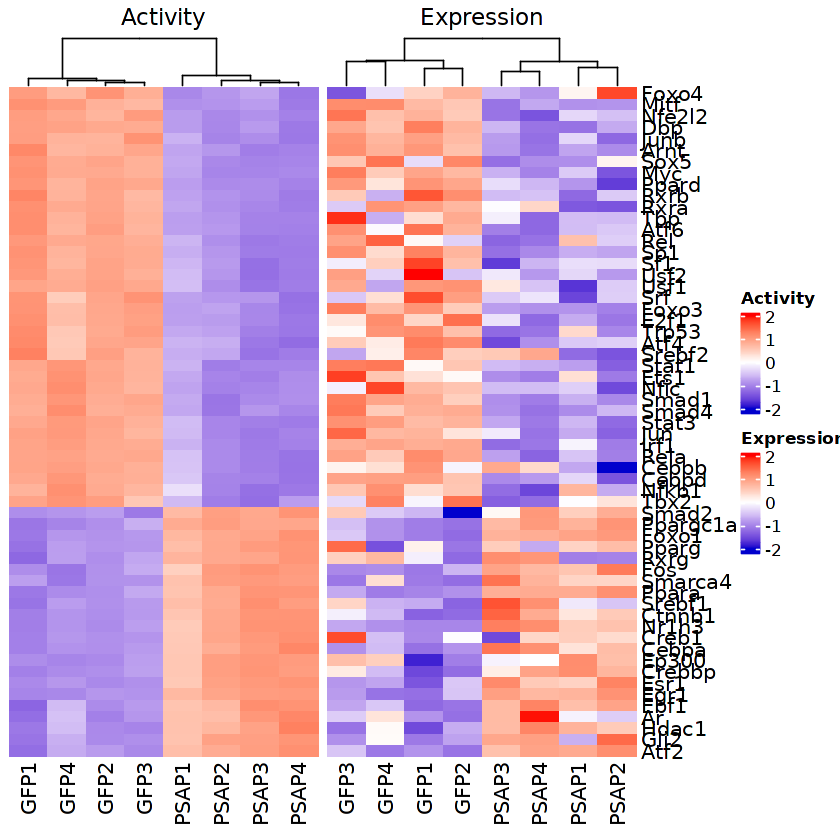

In [13]:
act.me <- TF_Activity(tfs, mDB, neweset, DErslt)
acts_mat = act.me$all_activities
Activity_heatmap(acts_mat, neweset)

### STEP 9: Build TF Network and Simulate Circuit

TF_Filter function constructs a filtered network of transcription factor interactions based on activity levels and known regulatory links, setting the stage for subsequent analysis and the transcriptional regulatory network plot.

In [14]:
tf_links = TF_Filter(acts_mat, mDB, miTh = .05, nbins = 8, corMethod = "spearman", DPI = T)

[1] 0
[1] 0.5


### STEP 10: Plot the transcription factor network

After the TF analysis, the plot_network function effectively visualizes the transcription factor network, enabling researchers to intuitively understand the complex regulatory interactions among TFs and their target genes.

In [15]:
plot_network(tf_links)


HTML widgets cannot be represented in plain text (need html)

### STEP 11: Run RACIPE simulation on the constructed GRN

Lastly, the RACIPE simulation is executed on the constructed gene regulatory network, allowing for the exploration of gene expression dynamics under varying regulatory parameters. The results can help to derive conclusions about the potential regulatory mechanisms at play and to identify key transcription factors that might be crucial in the system.

circuit file successfully loaded

Generating gene thresholds



generating thresholds for uniform distribution1...

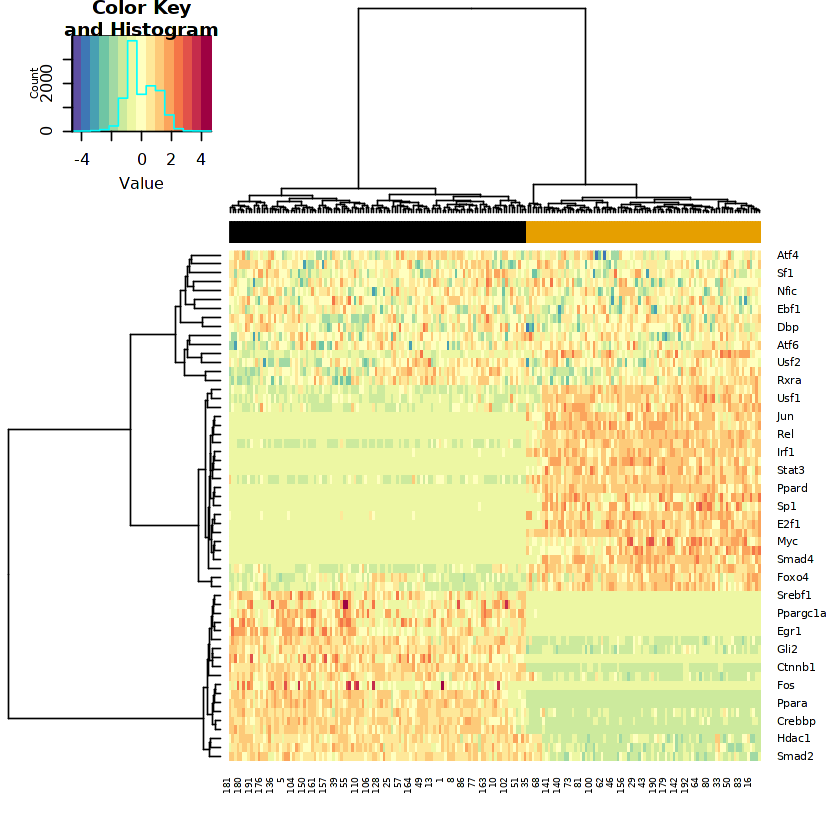

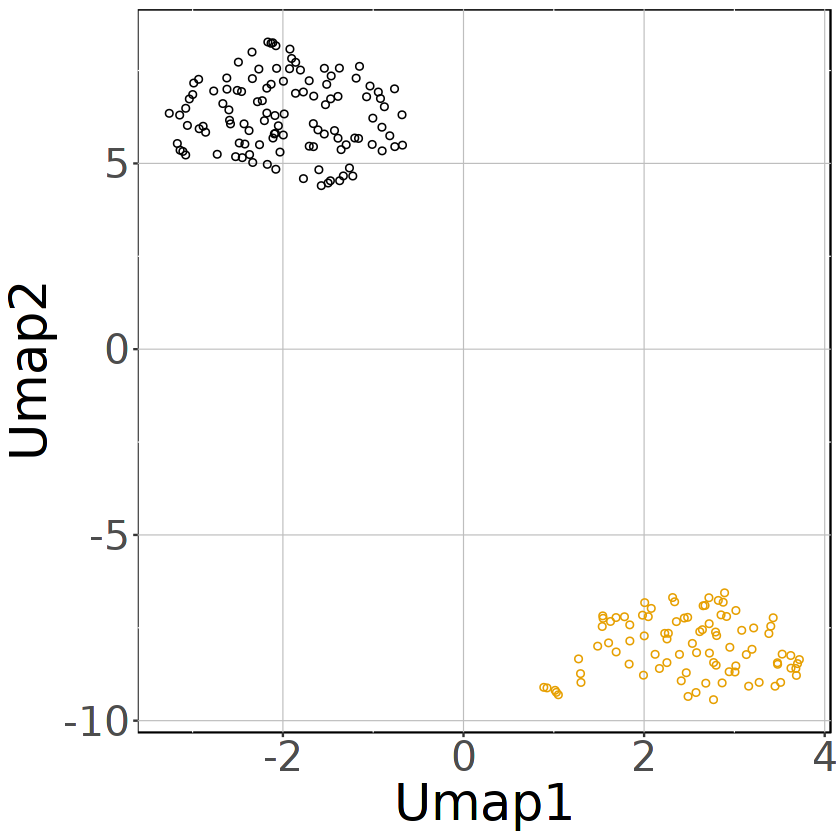

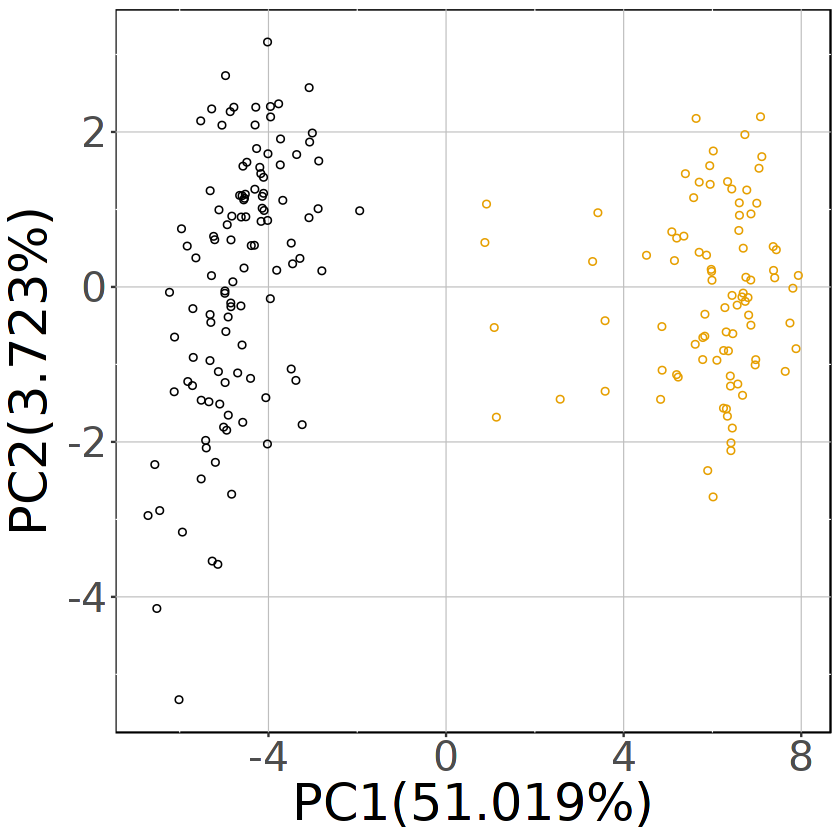

In [16]:
racipe_results <- sRACIPE::sracipeSimulate(circuit = tf_links, numModels = 200, plots = TRUE)